In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from google.colab import drive
import zipfile
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the zip file path
zip_file_path = "/content/drive/MyDrive/Colab Notebooks/6th_project/d1_+shutterphoto.zip" # Update with your actual path


In [ ]:

# Specify the directory to extract to
extract_dir = "/content/extracted_dataset"

# Create the extraction directory if it doesn't exist
!mkdir -p "$extract_dir"

# Unzip the file
try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
  print(f"Successfully extracted {zip_file_path} to {extract_dir}")

  dataset_path = extract_dir #Update the dataset path
except FileNotFoundError:
  print(f"Error: Zip file not found at {zip_file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

Successfully extracted /content/drive/MyDrive/Colab Notebooks/6th_project/d1_+shutterphoto.zip to /content/extracted_dataset


In [ ]:
# To read df from drive directoray ...

# dataset_path = "/content/drive/MyDrive/Colab Notebooks/6th_project/d1_refined _dara"  # Update with your actual path
# image_size = (224, 224)  # Adjust as needed for your model
# batch_size = 32

In [ ]:
dataset_path='/content/extracted_dataset/d1_+shutterphoto'
image_size = (224, 224)  # Adjust as needed for your model
batch_size = 32

In [ ]:
os.listdir(dataset_path)

['dry-skin', 'oily-skin', 'healthy', 'acne-prone-skin']

In [ ]:

import os

def count_images_per_label(dataset_path):

  label_counts = {}
  for label in os.listdir(dataset_path):
    label_dir = os.path.join(dataset_path, label)
    if os.path.isdir(label_dir):
      image_count = sum(1 for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f)))
      label_counts[label] = image_count
  return label_counts


dataset_path = '/content/extracted_dataset/d1_+shutterphoto'
image_counts = count_images_per_label(dataset_path)
for label, count in image_counts.items():
    print(f"Label: {label}, Image Count: {count}")

Label: dry-skin, Image Count: 226
Label: oily-skin, Image Count: 113
Label: healthy, Image Count: 150
Label: acne-prone-skin, Image Count: 187


In [ ]:

# Function to apply CLAHE and return the enhanced image (Contrast Limited Adaptive Histogram Equalization (CLAHE) )

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Create CLAHE and apply to the L-channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_l_channel = clahe.apply(l_channel)

    # Merge the enhanced L-channel with the original A and B channels
    enhanced_lab_image = cv2.merge((enhanced_l_channel, a_channel, b_channel))

    # Convert the LAB image back to BGR color space
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2BGR)

    image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

    # Optional: Convert to grayscale (commented out for now)
    # image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)
    return image_rgb




In [ ]:

images = []
labels = []

# Read the dataset folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                # Read image using OpenCV
                img = cv2.imread(image_path)
                if img is None:
                    raise ValueError(f"Unable to read image: {image_path}")

                # Resize the image
                img = cv2.resize(img, image_size)

                # Apply CLAHE
                img = apply_clahe(img, clip_limit=5, tile_grid_size=(8, 8))

                # Append processed image and its label
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Display data summary
print("Data preprocessing complete.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Data preprocessing complete.
X_train shape: (540, 224, 224, 3)
X_test shape: (136, 224, 224, 3)
y_train shape: (540,)
y_test shape: (136,)


In [ ]:
# prompt: write code to get no of image of each class in Xtrain data setsets

import numpy as np

def count_images_per_class(X_train, y_train):

    if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
        print("Error: Input arrays must be NumPy arrays.")
        return {}

    if X_train.shape[0] != y_train.shape[0] or X_train.shape[0] == 0 :
      print("Error: Input arrays must have the same number of elements and be non-empty.")
      return {}

    class_counts = {}
    unique_classes = np.unique(y_train)

    for class_label in unique_classes:
      class_counts[class_label] = np.sum(y_train == class_label)

    return class_counts


# Example usage: Assuming X_train and y_train are already defined
image_counts_per_class = count_images_per_class(X_train, y_train)

for class_label, count in image_counts_per_class.items():
    print(f"Class {class_label}: {count} images")


Class 0: 155 images
Class 1: 169 images
Class 2: 126 images
Class 3: 90 images


In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, horizontal_flip=True)

# Convert X_train & y_train to lists for easier manipulation
X_train, y_train = list(X_train), list(y_train)

# Calculate class counts dynamically
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Find target_size as the maximum class count
target_size = max(class_counts.values())

# Balance each class
for class_label, count in class_counts.items():
    class_indices = [i for i, y in enumerate(y_train) if y == class_label]

    if count < target_size:  # Need to oversample
        extra_needed = target_size - count
        for _ in range(extra_needed):
            idx = random.choice(class_indices)  # Randomly select an image
            augmented = datagen.random_transform(X_train[idx])  # Augment
            X_train.append(augmented)
            y_train.append(class_label)

    elif count > target_size:  # Need to undersample
        remove_indices = random.sample(class_indices, count - target_size)
        X_train = [X_train[i] for i in range(len(X_train)) if i not in remove_indices]
        y_train = [y_train[i] for i in range(len(y_train)) if i not in remove_indices]

# Convert back to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Verify new class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))


Balanced class distribution: {0: 169, 1: 169, 2: 169, 3: 169}


In [ ]:
print(y_train)

[1 1 0 2 0 1 3 2 1 2 0 0 0 0 0 0 3 2 1 3 2 0 2 1 0 0 0 2 3 2 0 1 1 0 1 3 3
 1 1 0 2 0 2 2 0 1 0 1 1 1 1 2 0 1 1 3 0 3 3 2 0 3 2 1 2 2 1 2 2 0 1 1 1 2
 3 3 0 3 3 1 3 1 0 2 1 1 3 1 0 0 3 1 3 2 0 3 1 1 3 1 3 2 2 0 1 1 0 3 1 3 1
 1 2 2 1 2 1 0 2 0 1 3 1 0 1 0 0 3 1 0 3 2 0 1 3 0 3 0 1 2 2 0 0 3 2 1 3 1
 0 0 1 2 0 0 1 3 0 0 1 3 1 1 0 0 1 0 0 0 3 0 1 1 2 1 1 0 3 1 3 1 0 1 2 0 3
 3 2 3 1 1 2 3 1 2 1 3 1 2 1 3 1 0 3 3 2 0 1 0 0 2 1 1 3 2 2 2 0 2 1 1 2 0
 0 1 1 0 0 1 2 0 3 0 3 0 3 0 1 1 0 3 1 2 3 1 1 3 0 2 2 1 0 0 1 0 2 2 0 0 1
 2 1 0 1 3 1 2 2 2 0 2 1 2 0 3 2 0 1 0 1 1 2 0 1 0 1 2 0 1 2 0 2 0 1 0 1 1
 3 3 0 0 2 1 1 0 2 2 3 0 3 2 1 2 2 3 0 2 0 1 1 2 2 3 1 2 2 1 2 0 0 2 2 0 1
 0 2 2 3 1 1 0 1 1 3 2 2 0 1 2 3 3 3 3 2 1 1 1 2 3 3 2 1 0 0 1 0 0 1 2 0 0
 1 0 2 1 1 1 0 0 0 0 2 0 0 3 2 0 1 3 0 2 3 0 3 2 0 2 3 3 2 2 1 0 0 2 2 0 0
 0 0 1 3 1 0 1 0 1 0 0 0 1 3 2 0 0 1 2 2 0 1 1 0 0 1 2 0 1 1 1 1 1 0 3 0 2
 3 2 2 0 1 1 2 1 0 0 1 1 1 1 0 2 1 1 1 3 3 3 2 2 0 3 1 1 0 2 2 1 0 2 1 0 0
 1 1 1 0 2 2 2 1 2 0 2 3 

In [ ]:
# prompt: write code see which class or folder what labels

# Print the unique class labels and their corresponding folder names
unique_labels = np.unique(labels)
class_mapping = {label: folder_name for label, folder_name in zip(unique_labels, le.inverse_transform(unique_labels))}
print("Class Labels and Folder Names:")
for label, folder_name in class_mapping.items():
  print(f"Label {label}: {folder_name}")


Class Labels and Folder Names:
Label 0: acne-prone-skin
Label 1: dry-skin
Label 2: healthy
Label 3: oily-skin


In [ ]:
print("Dataset path:", dataset_path)
print("Class names:", os.listdir(dataset_path))  # Check the contents


Dataset path: /content/extracted_dataset/d1_+shutterphoto
Class names: ['dry-skin', 'oily-skin', 'healthy', 'acne-prone-skin']


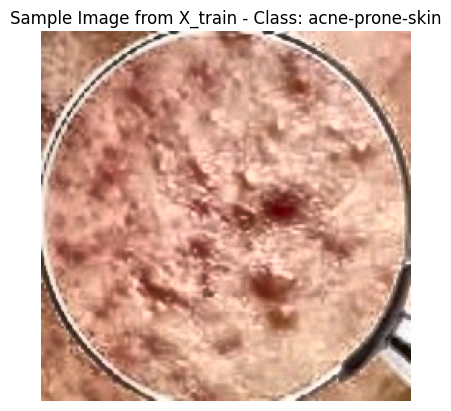

In [ ]:

image_index = 33
class_label = np.argmax(y_train[image_index])
class_name = le.inverse_transform([class_label])[0]
plt.imshow(X_train[image_index])
plt.title(f"Sample Image from X_train - Class: {class_name}")
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical # Import to_categorical

y_train = to_categorical(y_train, num_classes=len(le.classes_)) # Apply to_categorical
y_test = to_categorical(y_test, num_classes=len(le.classes_))   # Apply to_categorical

In [ ]:
y_train

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

# Mobilenet


In [ ]:
# Load the MobileNet model with pre-trained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Randomly zoom image
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'     # Points outside the boundaries are filled according to the given mode
)

In [ ]:
# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 908ms/step - accuracy: 0.4237 - loss: 1.3222 - val_accuracy: 0.7794 - val_loss: 0.6289
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7812 - loss: 0.5657 - val_accuracy: 0.7868 - val_loss: 0.6271


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.7632 - loss: 0.6368 - val_accuracy: 0.8088 - val_loss: 0.4814
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8750 - loss: 0.3361 - val_accuracy: 0.8088 - val_loss: 0.4856
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.8110 - loss: 0.4834 - val_accuracy: 0.8309 - val_loss: 0.3858
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8125 - loss: 0.3541 - val_accuracy: 0.8309 - val_loss: 0.3832
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.8845 - loss: 0.3469 - val_accuracy: 0.8456 - val_loss: 0.3637
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8125 - loss: 0.5069 - val_accuracy: 0.8456 - val_loss: 0.3608
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.8790 - loss: 0.3160 - val_accuracy: 0.8750 - val_loss: 0.3187
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9062 - loss: 0.3336 - val_accuracy: 0.

In [ ]:
# Save the model in HDF5 format
model.save('models/skin_type_model.h5')

# Save the model in Keras format
model.save('my_keras_model_2.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 435ms/step


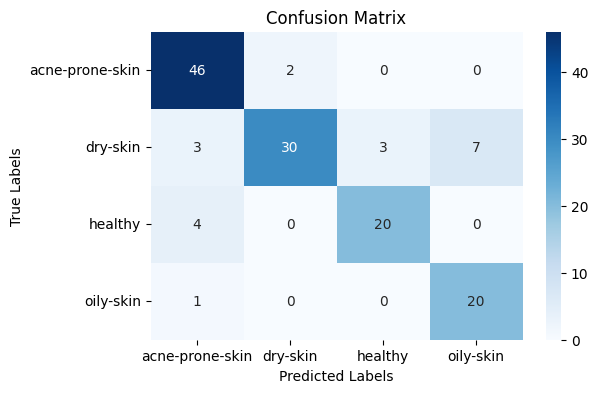

In [ ]:

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


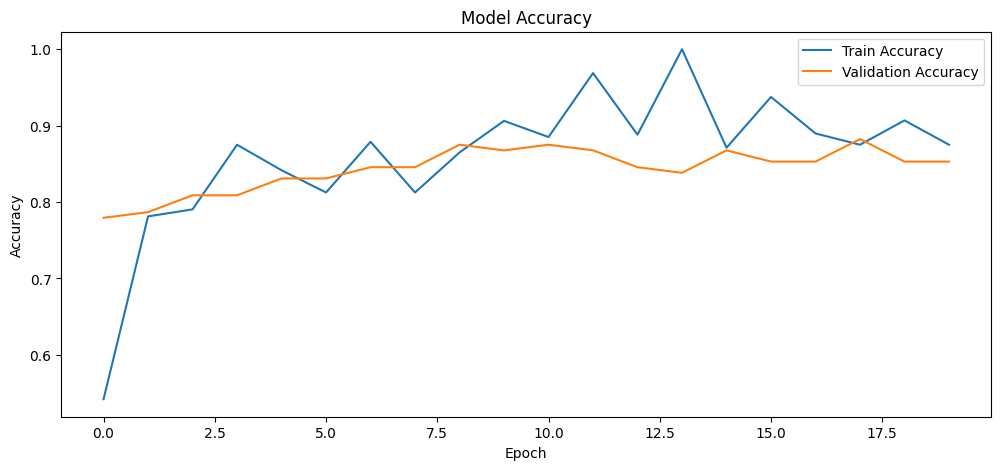

In [ ]:
# Plot training and validation performance
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

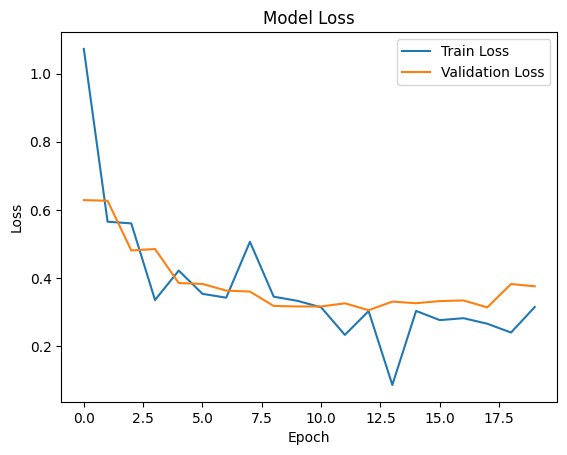

In [ ]:
# Plot loss
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()